-------------------------------------------------

This notebook is part of the [q4p (Quantum Computing for Programmers) series](https://github.com/CarloLepelaars/q4p). The original notebook can be found on [Github](https://github.com/CarloLepelaars/q4p/blob/main/nbs/05-grover.ipynb).

-------------------------------------------------

# 5. Grover's algorithm

In this lesson you will learn:
- Using **Grover's algorithm** for **unstructured search problems**.
- How Grover's algorithms provides a **quadratic speedup** over classical algorithms.
- A detailed walkthrough of Grover's algorithm.
- How to choose the optimal number of **Grover iterations** ($t$) for a given search problem.

**Grover's algorithm** addresses the problem of **searching solutions within an unstructured set**. Formally let's say we have a function $f$ that maps a binary string to a $0$ or $1$. We want to find the binary string $x$ such that $f(x) = 1$. This problem can be constructed as a **quantum query algorithm**, which features a similar setup with an oracle like we have seen in notebook 4 on Deutsch-Josza. Unlike Deutsch-Josza, Grover's doesn't require a promise for $f$, which would limit us in the functions we can evaluate. This algorithm will work on any function $f$ that evaluates a binary string and maps it to $0$ (not the solution) or $1$ (the solution). With Grover's algorithm we can achieve a **quadratic speedup** over classical algorithms for this unstructured search problem. 

Classically, we can solve the unstructured search problem by evaluating the function $f$ for all possible inputs. This requires $2^n$ evaluations for a bitstring of length $n$. This is the best we can do on a classical computer for a deterministic algorithm. Probabilistic algorithms can offer minor improvements, but often at a cost and still requires a number of queries linear in $2^n$. Grover's algorithms only requires $O(\sqrt{2^n})$ queries. Grover's algorithm is proven to be **asymptotically optimal** and **broadly applicable** for unstructured search. It is often used as a **subroutine for more complex algorithms**. 

The steps in Grover's algorithm are the following:

1. Initialize in equal superposition with Hadamard gates (same as in Deutsch-Josza)
2. Apply Grover operation $t$ times (we will discuss later how to choose $t$)
3. Measure the qubits, which yields a good solution given we choose $t$ correctly.


To start out we will take a 4-qubit system as an example with a target state of $|0101\rangle = 5$ in binary. For now we will run $t=2$ iterations of the Grover operation and later discuss how to choose $t$.

In [1]:
# Kaleido is used to convert Plotly to static png
!pip install -Uqq kaleido
# skq is used to construct and convert quantum circuits
!pip install -Uqq skq

In [2]:
import numpy as np

from skq.gates.qubit import GroverDiffusion, PhaseOracle, H, Measure
from skq.circuits import Circuit, Concat

import plotly.graph_objects as go

# Fix Plotly rendering in Jupyter forks.
# If you are running this notebook locally you can comment this out.
# This allows you to play with interactive Plotly plots.
import plotly.io as pio
pio.renderers.default = 'png'

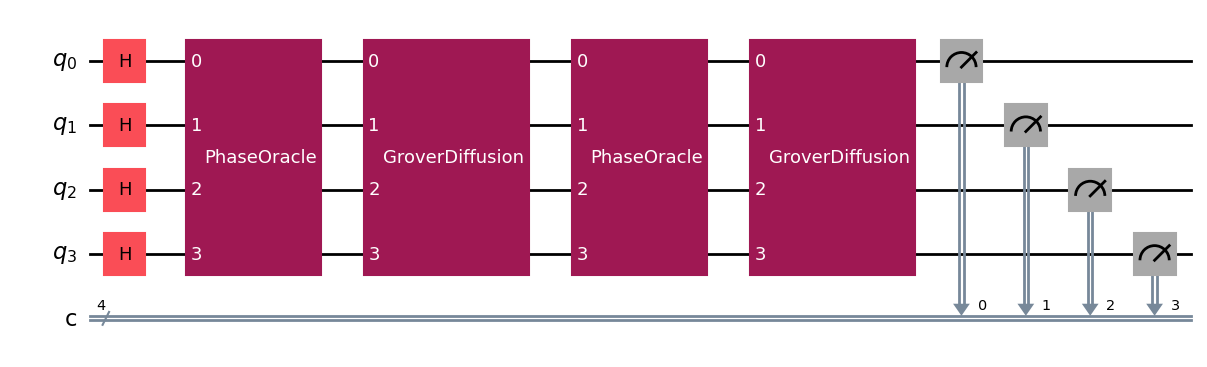

In [3]:
# State |0101> = 5 in binary
target_state = np.array([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0])

# Single Grover iteration can be iterated t times
t = 2
single_grover_iteration = [PhaseOracle(target_state),
                           GroverDiffusion(n_qubits=4)]
equal_superposition = Concat([H(), H(), H(), H()])

# 4-qubit Grover algorithm with solution |0101>
grover_circuit = Circuit([
                        # Step 1: Initialize in equal superposition
                        equal_superposition,
                        # Step 2: Apply Grover operation t times
                        *[gate for _ in range(t) for gate in single_grover_iteration], 
                        # Step 3: Measure all qubits
                        Measure()
                        ])
grover_circuit.draw(output="mpl")

When we run the circuit, our resulting probability distribution should be close to the target state. $0$ on all bits except the 10th bit. 

In [4]:
# Starting state for query algorithms is almost always the zero state (|0000> for 4 qubits)
four_qubit_zero_state = np.array([1]+[0]*(15))

result = grover_circuit(four_qubit_zero_state)
result

array([0.00610352, 0.00610352, 0.00610352, 0.00610352, 0.00610352,
       0.00610352, 0.00610352, 0.00610352, 0.00610352, 0.00610352,
       0.90844727, 0.00610352, 0.00610352, 0.00610352, 0.00610352,
       0.00610352])

Increasing $t$ can lead to better results up to a certain point. Using too many iterations will yield worse results. Try it out by adjusting $t$ and see what happens to the output.

In [5]:
# Result is sufficiently close so that if the round the probabilities to the nearest integer we get the target state.
np.allclose(result.round(0), target_state)

True

And as expected, we see a spike in the 10th bit when we look at the probability distribution. This correctly reflects target state $|0101\rangle$.

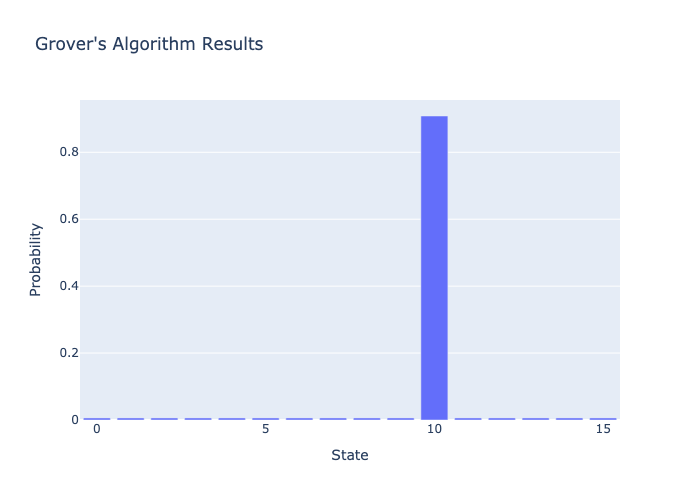

In [6]:
fig = go.Figure(data=[go.Bar(x=list(range(len(result))), y=result)])
fig.update_layout(
    title="Grover's Algorithm Results",
    xaxis_title="State",
    yaxis_title="Probability"
)
fig.show()

Let's take a closer look at the operations that are taking place. 

## Step 1: Initialize in equal superposition

We start out with the zero state $|0000\rangle$ and put all qubits in an **equal superposition** with Hadamard ($H$) gates.

$$
H^{\otimes 4} |0000\rangle = \frac{1}{\sqrt{16}} \sum_{x=0}^{15} |x\rangle = |+\rangle^{\otimes 4}
$$

Don't worry if this notation looks intimidating. Recall that an equal superposition of one qubit (i.e. the Plus state $|+\rangle$) is: 

$$
H |0\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle) = |+\rangle
$$

and the sum notation is just a generalization of this for $4$ qubits, which has $16$ possible **basis states**.

In [7]:
def matrix_heatmap(matrix: np.array, title: str = "Matrix Heatmap"):
    fig = go.Figure(data=go.Heatmap(
    z=np.real(matrix),
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    text=np.real(matrix).round(3),
    texttemplate='%{text}',
    textfont={"size": 10},
    hoverongaps=False
))
    fig.update_layout(
        title=title,
        xaxis_title="Column Index",
        yaxis_title="Row Index"
    )
    fig.show()


The matrix for an equal superposition of 4 qubits can look confusing, but note that it just distributes the amplitudes evenly over all basis states.

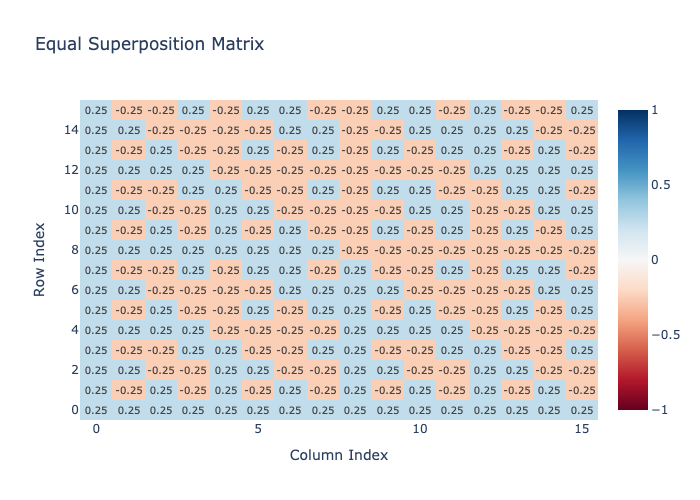

In [8]:
matrix_heatmap(equal_superposition.encoding_matrix, title="Equal Superposition Matrix")

In [9]:
equal_superposition_state = equal_superposition(four_qubit_zero_state)
equal_superposition_state

H([0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
   0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
   0.25+0.j, 0.25+0.j])

## Step 2: Apply Grover operation $t$ times

### Step 2.1: Phase Oracle

The phase oracle is similar to the oracle we have seen in the Deutsch-Josza algorithm. It flips the phase of the target state. It uses **constructive and destructive interference** to amplify the probability of the target state. After the phase we expect to see a **negative amplitude** on the 10th bit. 

Formally, the phase oracle is constructed as:

$$ U_f = I - 2|\psi\rangle\langle\psi| $$

where $|\psi\rangle$ is the target state.

In code constructing the oracle matrix looks like this.

In [10]:
oracle_matrix = np.eye(16) - 2 * np.outer(target_state, target_state.conj())
oracle_matrix.shape

(16, 16)

The construction of this oracle is handled by the `PhaseOracle` gate.

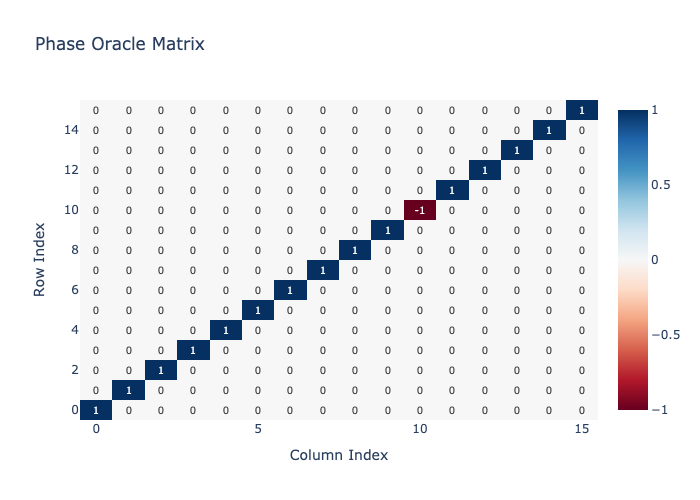

In [11]:
oracle = PhaseOracle(target_state)
matrix_heatmap(oracle, title="Phase Oracle Matrix")

Along the diagonal of `PhaseOracle` we see a spike in the 10th bit with a $-1$ amplitude and $1$ on all other bits. This is as expected and will flip the phase of the 10th bit to a negative amplitude.

In [12]:
phased_state = oracle(equal_superposition_state)
phased_state

array([ 0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
        0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j,
        0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j])

### Step 2.2: Grover Diffusion

Now that we have accomplished the phase flip it remains to now amplify the target state and reduce the amplitude of the other states. This is done with the Grover diffusion operator:

$$
U_s = 2|s\rangle\langle s| - I
$$

where $s$ is an equal superposition state. Practically for a 4-qubit system this results in a $16 \times 16$ matrix with $-0.875$ along the diagonal and $0.125$ everywhere else.



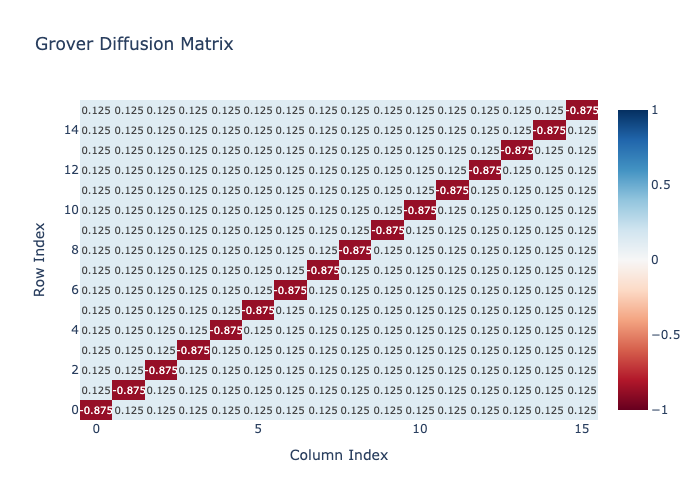

In [13]:
diffusion = GroverDiffusion(n_qubits=4)
matrix_heatmap(diffusion, title="Grover Diffusion Matrix")

In [14]:
diffused_state = diffusion(phased_state)
diffused_state

array([0.1875+0.j, 0.1875+0.j, 0.1875+0.j, 0.1875+0.j, 0.1875+0.j,
       0.1875+0.j, 0.1875+0.j, 0.1875+0.j, 0.1875+0.j, 0.1875+0.j,
       0.6875+0.j, 0.1875+0.j, 0.1875+0.j, 0.1875+0.j, 0.1875+0.j,
       0.1875+0.j])

We can see that after the diffusion transformation all amplitudes are positive again. The values that should be reduced are pushed closer to $0$ and the 10th bit is amplified upwards and now a positive value. This process can be repeated to get a better approximation of the target state, but too many iterations will yield worse results.

## Step 3: Measure the qubits

The last step will probably be familiar to you by now. We measure all 4 qubits (in the $Z$ basis) by taking the absolute value and squaring the amplitudes.

$$
P = |\psi|^2 = |\psi\rangle |\psi\rangle^*
$$

In [15]:
probabilities = Measure()(diffused_state)
probabilities

array([0.03515625, 0.03515625, 0.03515625, 0.03515625, 0.03515625,
       0.03515625, 0.03515625, 0.03515625, 0.03515625, 0.03515625,
       0.47265625, 0.03515625, 0.03515625, 0.03515625, 0.03515625,
       0.03515625])

The resulting state will be close to the target state even for one Grover iteration. For larger circuits we can expect to need more iterations to get accurate results. In the next section we will discuss how to choose the optimal number of iterations ($t$).

# Choosing $t$

There is a formal way to choose the optimal number of Grover iterations $t$ for a given problem. Using a lower $t$ might still give a good solution, but will be suboptimal. The optimal $t$ is given by:

$$
t = \left\lfloor \frac{\pi}{4\arcsin(\sqrt{M/2^n})} - \frac{1}{2} \right\rfloor
$$

where $M$ is the number of solutions to the search problem and $n$ is the number of qubits.

For example, for a 4-qubit the optimal $t$ is given by:

$$
t = \left\lfloor \frac{\pi}{4\arcsin(\sqrt{1/16})} - \frac{1}{2} \right\rfloor = \lfloor 2.608... \rfloor = 2
$$

So we only need $2$ iterations to get the correct solution for a 4-qubit system. Run more iterations and the quantum state will start to deteriorate.

In [16]:
def optimal_t(M, n):
    """Calculate the optimal number of Grover iterations for a given problem."""
    return int(np.floor(np.pi/(4*np.arcsin(np.sqrt(M/2**n))) - 1/2))

M = 1
n = 4
four_qubit_optimal_t = optimal_t(M, n)
print(f"Optimal number of Grover iterations for {M} solution in {n} qubits: '{four_qubit_optimal_t}'")

Optimal number of Grover iterations for 1 solution in 4 qubits: '2'


Let's check out what it would take to solve a 50-qubit problem.

In [17]:
M = 1
n = 50
fifty_qubit_optimal_t = optimal_t(M, n)
print(f"Optimal number of Grover iterations for {M} solution in {n} qubits: '{fifty_qubit_optimal_t:,}'")

Optimal number of Grover iterations for 1 solution in 50 qubits: '26,353,588'


While this looks like a very large number of iterations, it is still a lot better than the worst case scenario of $2^n$ classical queries.

In [18]:
classical_queries = 2**50
quantum_queries = fifty_qubit_optimal_t
speedup = classical_queries / quantum_queries
print(f"Number of classical queries needed for 50 bits: '{classical_queries:,}'")
print(f"Number of Grover iterations needed: '{quantum_queries:,}'")
print(f"Quantum speedup factor: '{speedup:,.0f}x'")

Number of classical queries needed for 50 bits: '1,125,899,906,842,624'
Number of Grover iterations needed: '26,353,588'
Quantum speedup factor: '42,722,832x'


Note that the more solutions there are to the search problem, the less iterations we need. Also note that computing $t$ in this way requires us to know the number of solutions in advance. 

If we don't know the number of solutions in advance, there is a heuristic that turns out to work well in practice. This is to choose a random $t$ within range:

$$
t \in \{1, ..., \left\lfloor \frac{\pi \sqrt{2^n}}{4} \right\rfloor\}
$$

Using this heuristic the probability of finding a solution if one exists will be at least 40%. To boost the probability we can multiply $t$ by a constant factor. We can also start with a small $t$ and keep increasing it until we find a solution.

In [19]:
def random_t(n):
    """ Heuristic to choose t if we don't know the number of solutions. """
    return np.random.randint(1, np.floor(np.pi * np.sqrt(2**n) / 4))

print(f"Random t for 50 qubits if numbers of solutions are unknown: '{random_t(50):,}'")

Random t for 50 qubits if numbers of solutions are unknown: '4,847,616'


We have shown that for large unstructured search problems, quantum computers can bring enormous benefits over what classical computers can do. The main obstacle to leveraging this speedup in everyday computing is that current quantum computer have noisy qubits. The largest quantum computer available at IBM is called [Heron](https://en.wikipedia.org/wiki/IBM_Heron) and has 156 physical (i.e. noisy) qubits. What we are aiming for is reliable [logical qubits](https://en.wikipedia.org/wiki/Physical_and_logical_qubits). There is progress in creating logical qubits out of **physical qubits** through **quantum error correction**, which we will discuss in notebook 7. The calculation above assumes we have 50 logical qubits at our disposal.

There are algorithms which can illustrate the power of quantum computers even better than Grover's algorithm. There are algorithms that can provide exponential speedups over classical algorithms. One of the most well known is **Shor's** algorithm for integer factorization, which is used in popular cryptography schemes. We will discuss how to this algorithm works in the next notebook.

-------------------------------------------------

This notebook is part of the [q4p (Quantum Computing for Programmers) series](https://github.com/CarloLepelaars/q4p). The original notebook can be found on [Github](https://github.com/CarloLepelaars/q4p/blob/main/nbs/05-grover.ipynb).

-------------------------------------------------